In [1]:
pip install scikit-commpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install import_ipynb

Note: you may need to restart the kernel to use updated packages.


In [30]:
import numpy as np
import decimal
from numpy.linalg import inv
from commpy.modulation import QAMModem
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Conv1D
from decimal import getcontext
import matplotlib.pyplot as plt

getcontext().Emax = 600000000000
import import_ipynb
from Utils import *
IBO = 3
p = 1.1
q = 4
Vsat = 1.9
G = 16
A = -345
B = 0.17
Mr = 10
Mt = 100
M = 16
N_bits = Mr * np.log2(M)
SNRdb = decimal.Decimal(60000000000)
Niter = 50
mu1 = 0.0017
lamda = 0.00071
mu2 = 1
eps = 1e-2

In [6]:
IH1=np.zeros((1000, 2000))
OH1=np.zeros((1000, 4620))
K0, sigma_2d = Basic_Nonlinear_Distortion_Model(A, B, q, p, G, Vsat, IBO)

""" Il s'agit de modeliser le canal de transmission par une matrice complex."""
for t in range(1000):
    N_bits = Mr * np.log2(M)
    x_gd = np.zeros((Mt, 1))
    gdx1 = np.zeros((Mt, Niter))
    d = np.zeros((Mt, 1))
    S = np.zeros((10000, 20))
    X = np.zeros((10000, 200))
    H = (1 / np.sqrt(2 * Mt)) * (np.random.randn(Mr, Mt) + 1j * np.random.randn(Mr, Mt))
    HR = H.flatten()
    realh = np.real(HR)
    imagh = np.imag(HR)
    Hr = np.concatenate((realh, imagh), axis=0)
    Hr = np.reshape(Hr, (2000, 1)).T
    HH = Hr
    HH.tolist()
    """Il s'agit de génerer pour chaque H; 1000000 symboles S et 1000000 symboles précodés X.
       C'est l'algorithme de Gradient descente qui permet de minimiser l’erreur quadratique moyenne (MSE) entre les symboles prévus S et les sorties de PA passant par le canal H
       Dans laquelle nous estimons x en minimisant la fonction de coût J (x) par rapport à x et estimons le vecteur de distorsion à travers le chemin de rétroaction. 
       Ainsi, dans la (l + 1) -ième itération, peut être exprimée comme x(l+1) = x(l) −Δx(l) avec Δx(l) = λ∇xJ(x(l),d(l)). """
    for j in range(10000):
        bits = np.random.randint(2, size=int(N_bits))  
        QAM16 = QAMModem(16)  
        z = QAM16.modulate(bits)
        Z = np.reshape(z, (1, 10))
        reals = np.real(Z)
        imags = np.imag(Z)
        s = np.concatenate((reals, imags), axis=1)
        S[j] = s
        for i in range(Niter):
            gdx1 = 2 * np.conj(K0 * np.transpose(H)).dot(K0 * H.dot(x_gd) + H.dot(d)- Z.T)
            x_gd = x_gd - mu1 * gdx1
            realx = np.real(x_gd)
            imagx = np.imag(x_gd)
            x_z = np.concatenate((realx, imagx), axis=0).reshape((200))
            X[j] = x_z
            val_IBO_m1dB = (((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G))
            coeff_IBO_m1dB = (val_IBO_m1dB * np.sqrt((1 / np.var(x_gd))) * np.sqrt(10 ** (-IBO / 10)))  
            vin2 = coeff_IBO_m1dB * x_gd
            vout2 = hpa_sspa_modif_rapp(vin2, Vsat, p, q, G, A, B) 
            K0, sigma2_d = find_K0_sigma2_d(vin2, vout2)
            d = vout2 - K0 * vin2  
            y_gd =vout2 / coeff_IBO_m1dB
        MSEgd=np.mean(np.abs((H.dot(y_gd)) - Z.T) ** 2) / (np.mean(np.abs(Z) ** 2))
    NMSEGD = 10 * np.log10(np.mean(MSEgd))
    print('nmsede GD',NMSEGD)
    "Base d'apprentissage"
    X_train = S[:9000, :]
    y_train = X[:9000, :]
    "Base de test"
    X_test = S[9000:, :]
    y_test = X[9000:, :]
    model=Sequential()
    model.add(Dense(units=20, kernel_initializer="uniform", activation="linear", input_dim=20))
    model.add(Dense(units=200, kernel_initializer="uniform", activation="linear"))
    model.compile(optimizer="Adamax", loss="mae", metrics=['mse'])
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=1000,
        epochs=300,
        shuffle=True,
    )
    #Calcul d NMSE
    y_pred = model.predict(X_train)
    y_predt = model.predict(X_test)
    NMSE = np.zeros([1000, 1])
    recievehh = np.zeros([1000, 10], dtype=complex)
    Y_gdr = y_predt[:1000, :100]
    Y_gdi = 1j * y_predt[:1000, 100:]
    Y_gd = Y_gdr + Y_gdi
    Shr = X_test[:1000, :10]
    Shi = 1j * X_test[:1000, 10:20]
    SSh = Shr + Shi
    for i in range(1000):
        val_IBO_m1dB = (((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G))
        coeff_IBO_m1dB = (val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd[i]))) * np.sqrt(10 ** (-IBO / 10)))
        vin22 = coeff_IBO_m1dB * Y_gd[i]
        vout22 = hpa_sspa_modif_rapp(vin22, Vsat, p, q, G, A, B)
        Y_gd_amp = vout22 / coeff_IBO_m1dB
        recieveh = (H.dot(Y_gd_amp)).reshape((10))
        recievehh[i] = recieveh
        NMSE[i] = np.mean(np.abs(SSh[i] - recieveh) ** 2) / np.mean(np.abs(SSh[i]) ** 2)
    NMSEdb = 10 * np.log10(np.mean(NMSE))
    print(NMSEdb )
    if NMSEdb< -32 :
        """ Recover the weight vector of our model NN1 using the function get_weights ().
        This vector will be the desired output of the NN2 model."""
        first_layer_weights =model.layers[0].get_weights()[0] 
        first=first_layer_weights.flatten()
        first_layer_biases  = model.layers[0].get_weights()[1]
        first_layer=np.concatenate((first,first_layer_biases),axis=0)
        second_layer_weights = model.layers[1].get_weights()[0]
        second=second_layer_weights.flatten()
        second_layer_biases  = model.layers[1].get_weights()[1]
        second_layer=np.concatenate((second,second_layer_biases),axis=0)
        weights=np.concatenate((first_layer,second_layer),axis=0)
        weights.tolist()
        print (t)
        IH1[t]=HH
        OH1[t]=weights
        save('dataI28.npy',IH1)
        save('dataO28.npy',OH1)
        print('canal numero ',t,'Saved')
    else:
        print('canal numero ',t,'Condition not satisfied')

nmsede GD -38.02613710942357
Epoch 1/300
9/9 [==============================] - 0s 11ms/step - loss: 0.0447 - mse: 0.0032 - val_loss: 0.0406 - val_mse: 0.0026
Epoch 2/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0381 - mse: 0.0023 - val_loss: 0.0360 - val_mse: 0.0021
Epoch 3/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0343 - mse: 0.0019 - val_loss: 0.0327 - val_mse: 0.0017
Epoch 4/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0312 - mse: 0.0016 - val_loss: 0.0297 - val_mse: 0.0014
Epoch 5/300
9/9 [==============================] - 0s 2ms/step - loss: 0.0281 - mse: 0.0013 - val_loss: 0.0267 - val_mse: 0.0012
Epoch 6/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0252 - mse: 0.0011 - val_loss: 0.0239 - val_mse: 9.4530e-04
Epoch 7/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0224 - mse: 8.4424e-04 - val_loss: 0.0211 - val_mse: 7.5381e-04
Epoch 8/300
9/9 [==============================] - 0s 3

KeyboardInterrupt: 

In [21]:
pip install -U keras-tuner

     |################################| 61kB 8.6MB/s  eta 0:00:01
     |################################| 829kB 25.6MB/s eta 0:00:01
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73201 sha256=a7829732f378e935f0645069fa68fa92eb3b1e1f35ac5ec3b1aa7c0455fb3b6c
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491058 sha256=cd5998ee913050a8b0fceebe0ef4bf8ca523b3f6152724351153a71953f4a5b7
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15357 sha256=e3cf2757e830526897b6b11197d9ff68b326b3efd5dc9060d3cff9420dfef215
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner future terminaltables
Note: you ma

In [47]:
IH1=load('dataI1.npy')[np.nonzero(load('dataI1.npy' ))]
OH1=load('dataO1.npy')[np.nonzero(load('dataO1.npy' ))]
IH2=load('dataI2.npy')[np.nonzero(load('dataI2.npy' ))]
OH2=load('dataO2.npy')[np.nonzero(load('dataO2.npy' ))]
IH3=load('dataI3.npy')[np.nonzero(load('dataI3.npy' ))]
OH3=load('dataO3.npy')[np.nonzero(load('dataO3.npy' ))]
IH6=load('dataI6.npy')[np.nonzero(load('dataI6.npy' ))]
OH6=load('dataO6.npy')[np.nonzero(load('dataO6.npy' ))]
IH5=load('dataI5.npy')[np.nonzero(load('dataI5.npy'))]
OH5=load('dataO5.npy')[np.nonzero(load('dataO5.npy'))]
IH4=load('dataI4.npy')[np.nonzero(load('dataI4.npy' ))]
OH4=load('dataO4.npy')[np.nonzero(load('dataO4.npy' ))]
IH8=load('dataI8.npy')[np.nonzero(load('dataI8.npy' ))]
OH8=load('dataO8.npy')[np.nonzero(load('dataO8.npy' ))]
IH9=load('dataI9.npy')[np.nonzero(load('dataI9.npy'))]
OH9=load('dataO9.npy')[np.nonzero(load('dataO9.npy'))]
IH10=load('dataI10.npy')[np.nonzero(load('dataI10.npy' ))]
OH10=load('dataO10.npy')[np.nonzero(load('dataO10.npy' ))]
IH11=load('dataI11.npy')[np.nonzero(load('dataI11.npy' ))]
OH11=load('dataO11.npy')[np.nonzero(load('dataO11.npy' ))]
IH12=load('dataI12.npy')[np.nonzero(load('dataI12.npy'))]
OH12=load('dataO12.npy')[np.nonzero(load('dataO12.npy'))]
IH7=load('dataI7.npy')[np.nonzero(load('dataI7.npy' ))]
OH7=load('dataO7.npy')[np.nonzero(load('dataO7.npy' ))]
IH13=load('dataI13.npy')[np.nonzero(load('dataI13.npy'))]
OH13=load('dataO13.npy')[np.nonzero(load('dataO13.npy'))]
IH14=load('dataI14.npy')[np.nonzero(load('dataI14.npy'))]
OH14=load('dataO14.npy')[np.nonzero(load('dataO14.npy'))]
IH15=load('dataI15.npy')[np.nonzero(load('dataI15.npy'))]
OH15=load('dataO15.npy')[np.nonzero(load('dataO15.npy'))]
IH16=load('dataI16.npy')[np.nonzero(load('dataI16.npy'))]
OH16=load('dataO16.npy')[np.nonzero(load('dataO16.npy'))]
IH17=load('dataI17.npy')[np.nonzero(load('dataI17.npy'))]
OH17=load('dataO17.npy')[np.nonzero(load('dataO17.npy'))]
IH18=load('dataI18.npy')[np.nonzero(load('dataI18.npy'))]
OH18=load('dataO18.npy')[np.nonzero(load('dataO18.npy'))]
IH19=load('dataI19.npy')[np.nonzero(load('dataI19.npy'))]
OH19=load('dataO19.npy')[np.nonzero(load('dataO19.npy'))]
IH20=load('dataI20.npy')[np.nonzero(load('dataI20.npy'))]
OH20=load('dataO20.npy')[np.nonzero(load('dataO20.npy'))]
IH21=load('dataI21.npy')[np.nonzero(load('dataI21.npy'))]
OH21=load('dataO21.npy')[np.nonzero(load('dataO21.npy'))]
IH22=load('dataI22.npy')[np.nonzero(load('dataI22.npy'))]
OH22=load('dataO22.npy')[np.nonzero(load('dataO22.npy'))]
IH23=load('dataI23.npy')[np.nonzero(load('dataI23.npy'))]
OH23=load('dataO23.npy')[np.nonzero(load('dataO23.npy'))]
IH24=load('dataI24.npy')[np.nonzero(load('dataI24.npy'))]
OH24=load('dataO24.npy')[np.nonzero(load('dataO24.npy'))]
IH25=load('dataI25.npy')[np.nonzero(load('dataI25.npy'))]
OH25=load('dataO25.npy')[np.nonzero(load('dataO25.npy'))]
IH26=load('dataI26.npy')[np.nonzero(load('dataI26.npy'))]
OH26=load('dataO26.npy')[np.nonzero(load('dataO26.npy'))]
IH27=load('dataI27.npy')[np.nonzero(load('dataI27.npy'))]
OH27=load('dataO27.npy')[np.nonzero(load('dataO27.npy'))]
IHH=np.concatenate((IH1,IH2,IH3,IH4,IH5,IH6,IH8,IH9,IH10,IH11,IH12,IH7,IH13,IH14,IH15,IH16,IH17,IH18,IH19,IH20,IH21,IH22,IH23,IH24,IH25,IH26,IH27),axis=0)
OHH=np.concatenate((OH1,OH2,OH3,OH4,OH5,OH6,OH8,OH9,OH10,OH11,OH12,OH7,OH13,OH14,OH15,OH16,OH17,OH18,OH19,OH20,OH21,OH22,OH23,OH24,OH25,OH26,OH27),axis=0)
IHHH=IHH.reshape((10902,2000))
OHHH=OHH.reshape((10902,4620))
print(IHHH.shape)    
print(OHHH.shape)
X_trainN2 = IHHH[:10000,:]
y_trainN2 = OHHH[:10000,:]
X_testN2= IHHH[10000:,:]
y_testN2 = OHHH[10000:,:]

(10902, 2000)
(10902, 4620)


In [66]:
from numpy import  newaxis
X_trainN22=X_trainN2[:,:,newaxis]
X_testN22= X_testN2[:,:,newaxis]

##NN2

In [70]:
"""Create NN2 Model which contains 2 hidden layers; 
The first layer have 1000 neurones (input_dim=2000)
The second have 4620 neurones (output_dim=4620) """
modell=Sequential()
modell.add(Dense(units=1000, kernel_initializer="uniform", activation="linear", input_dim=2000))
modell.add(Dropout(0.2))
#modell.add(Conv1D(filters=32, kernel_size=2, strides=1, activation='relu',padding='causal'))
modell.add(Dense(units=4620, kernel_initializer="uniform", activation="linear"))
modell.compile(optimizer="Adam", loss="mae", metrics=['mse'])
history2 = modell.fit(X_trainN2,y_trainN2,validation_data=(X_testN2, y_testN2),batch_size=1000,epochs=300,shuffle=True)


Epoch 1/300
10/10 [==============================] - 1s 86ms/step - loss: 0.0747 - mse: 0.0088 - val_loss: 0.0608 - val_mse: 0.0058
Epoch 2/300
10/10 [==============================] - 1s 88ms/step - loss: 0.0600 - mse: 0.0057 - val_loss: 0.0498 - val_mse: 0.0039
Epoch 3/300
10/10 [==============================] - 1s 83ms/step - loss: 0.0483 - mse: 0.0037 - val_loss: 0.0416 - val_mse: 0.0027
Epoch 4/300
10/10 [==============================] - 1s 85ms/step - loss: 0.0403 - mse: 0.0026 - val_loss: 0.0361 - val_mse: 0.0021
Epoch 5/300
10/10 [==============================] - 1s 83ms/step - loss: 0.0354 - mse: 0.0020 - val_loss: 0.0328 - val_mse: 0.0017
Epoch 6/300
10/10 [==============================] - 1s 89ms/step - loss: 0.0324 - mse: 0.0017 - val_loss: 0.0309 - val_mse: 0.0015
Epoch 7/300
10/10 [==============================] - 1s 85ms/step - loss: 0.0308 - mse: 0.0015 - val_loss: 0.0298 - val_mse: 0.0014
Epoch 8/300
10/10 [==============================] - 1s 83ms/step - loss: 0.

KeyboardInterrupt: 

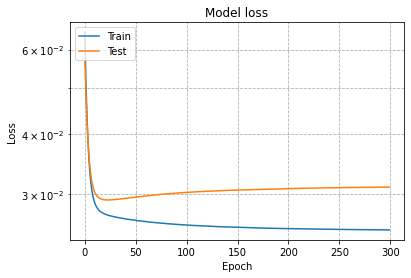

In [71]:
# Loss representation
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()
# Make predictions
y_pred2 = modell.predict(X_trainN2)
y_predt2 = modell.predict(X_testN2)


In [72]:
first_layer_weightstt=y_predt2[:,:400]
print(first_layer_weightstt.shape)
first_layer_biasestt=y_predt2[:,400:420]
print(first_layer_biasestt.shape)
second_layer_weightstt=y_predt2[:,420:4420]
print(second_layer_weightstt.shape)
second_layer_biasestt=y_predt2[:,4420:]
print(second_layer_biasestt.shape)

(902, 400)
(902, 20)
(902, 4000)
(902, 200)


In [73]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [74]:
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
Ih11=load('IH11.npy')[np.nonzero(load('IH11.npy' ))]
Oh11=load('OH11.npy')[np.nonzero(load('OH11.npy' ))]
Ih11=Ih11.reshape((429,2000))
Oh11=Oh11.reshape((429,4620))
y_predt3= modell.predict(Ih11[:1,:])
print(mean_absolute_error(y_predt3[:1,:],Oh11[:1,:]))


0.06957479048566328


6.4504968727466


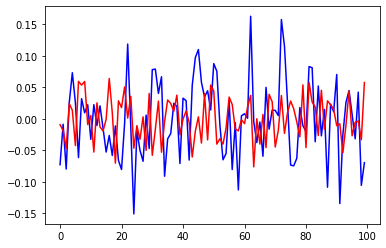

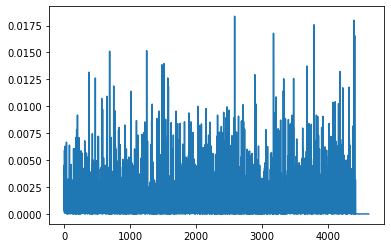

In [75]:
plt.figure()
plt.plot(y_predt[1,:100],'b')
plt.plot(y_testN2[1,:100],'r')
ERR=(abs(y_predt2[5,:]-y_testN2[5,:])**2)
print(sum(ERR))
plt.figure()
plt.plot(ERR)

In [76]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
for t in range(3000):
    NMSE2 = np.zeros((3000, 1))
    H2r=X_testN2[t,:1000]
    H2i=1j*X_testN2[t,1000:]
    H02=H2r+H2i
    H2=H02.reshape((10,100))
    print('Canal numero:',t)
    S_NN1 =X_test[:3000,:]
    modelll=Sequential()
    modelll.add(Dense(units=20, kernel_initializer="uniform", activation="linear", input_dim=20))
    first_weightstt=first_layer_weightstt[t,:400]
    L1=first_weightstt.reshape((20,20))
    first_layer_biasestt=y_predt2[t,400:420]
    L2=first_layer_biasestt
    modelll.layers[0].set_weights([L1,L2])
    modelll.add(Dense(units=200, kernel_initializer="uniform", activation="linear"))
    second_weightstt=y_predt2[t,420:4420]
    L3=second_weightstt.reshape((20,200))
    second_layer_biasestt=y_predt2[t,4420:4620]
    L4=second_layer_biasestt
    modelll.layers[1].set_weights([L3,L4]) 
    y_predt22 = modelll.predict(S_NN1)
    Y_gd2r = y_predt22[:3000,:100]
    Y_gd2i = 1j * y_predt22[:3000,100:]
    Y_gd2 = Y_gd2r + Y_gd2i
    print(Y_gd2.shape)
    Shr2 = S_NN1[:3000, :10]
    Shi2 = 1j * S_NN1[:3000, 10:20]
    SSh2 = Shr2 + Shi2
    for n in range(1000):
        val_IBO_m1dB = (((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G))
        coeff_IBO_m1dB22=val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd2[n]))) * np.sqrt(10 ** (-IBO / 10))
        vin222 = coeff_IBO_m1dB22 * Y_gd2[n]
        vout222 = hpa_sspa_modif_rapp(vin222, Vsat, p, q, G, A, B)
        Y_gd_amp2 = vout222 / coeff_IBO_m1dB22
        recieveh2 = (H2.dot(Y_gd_amp2)).reshape((10))
        NMSE2[n]= np.mean(np.abs(SSh2[n] - recieveh2) ** 2) / np.mean(np.abs(SSh2[n]) ** 2)
    NMSE2db = 10 * np.log10(np.mean(NMSE2)) 
    print('NMSE de canal numero',t ,'est: ',NMSE2db) 
       


Canal numero: 0
(1000, 100)
NMSE de canal numero 0 est:  -4.74530732040162
Canal numero: 1
(1000, 100)
NMSE de canal numero 1 est:  -4.740231552061695
Canal numero: 2
(1000, 100)
NMSE de canal numero 2 est:  -4.761294238580575
Canal numero: 3
(1000, 100)
NMSE de canal numero 3 est:  -4.748675623866997
Canal numero: 4
(1000, 100)
NMSE de canal numero 4 est:  -4.822150562810103
Canal numero: 5
(1000, 100)
NMSE de canal numero 5 est:  -4.801538011336186
Canal numero: 6
(1000, 100)
NMSE de canal numero 6 est:  -4.759326203258151
Canal numero: 7
(1000, 100)
NMSE de canal numero 7 est:  -4.788089040688849
Canal numero: 8
(1000, 100)
NMSE de canal numero 8 est:  -4.754149910319583
Canal numero: 9
(1000, 100)
NMSE de canal numero 9 est:  -4.751431975138569
Canal numero: 10
(1000, 100)
NMSE de canal numero 10 est:  -4.711291968053588
Canal numero: 11
(1000, 100)
NMSE de canal numero 11 est:  -4.712600919254113
Canal numero: 12
(1000, 100)
NMSE de canal numero 12 est:  -4.748672312742756
Canal n

KeyboardInterrupt: 

In [77]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
for t in range(3000):
    H2r=X_testN2[t,:1000]
    H2i=1j*X_testN2[t,1000:]
    H02=H2r+H2i
    H2=H02.reshape((10,100))
    print('Canal numero:',t)
    S_NN1 =X_test[:3000,:]
    modelll=Sequential()
    modelll.add(Dense(units=20, kernel_initializer="uniform", activation="linear", input_dim=20))
    first_weightsttV=y_testN2[t,:400]
    LV1=first_weightsttV.reshape((20,20))
    first_layer_biasesttV=y_testN2[t,400:420]
    LV2=first_layer_biasesttV
    modelll.layers[0].set_weights([LV1,LV2])
    modelll.add(Dense(units=200, kernel_initializer="uniform", activation="linear"))
    second_weightsttV=y_testN2[t,420:4420]
    LV3=second_weightsttV.reshape((20,200))
    second_layer_biasesttV=y_testN2[t,4420:4620]
    LV4=second_layer_biasesttV
    modelll.layers[1].set_weights([LV3,LV4]) 
    y_predt22v = modelll.predict(S_NN1)
    NMSE22 = np.zeros((3000, 1))
    Y_gd2r = y_predt22v[:3000,:100]
    Y_gd2i = 1j * y_predt22v[:3000,100:]
    Y_gd2 = Y_gd2r + Y_gd2i
    print(Y_gd2.shape)
    Shr2 = S_NN1[:3000, :10]
    Shi2 = 1j * S_NN1[:3000, 10:20]
    SSh2 = Shr2 + Shi2
    for n in range(1000):
        val_IBO_m1dB = (((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G))
        coeff_IBO_m1dB22=val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd2[n]))) * np.sqrt(10 ** (-IBO / 10))
        vin222 = coeff_IBO_m1dB22 * Y_gd2[n]
        vout222 = hpa_sspa_modif_rapp(vin222, Vsat, p, q, G, A, B)
        Y_gd_amp2 = vout222 / coeff_IBO_m1dB22
        recieveh2 = (H2.dot(Y_gd_amp2)).reshape((10))
        NMSE22[n]= np.mean(np.abs(SSh2[n] - recieveh2) ** 2) / np.mean(np.abs(SSh2[n]) ** 2)
    NMSE22db = 10 * np.log10(np.mean(NMSE22)) 
    print('NMSE de canal numero',t ,'est: ',NMSE22db) 

Canal numero: 0
(1000, 100)
NMSE de canal numero 0 est:  -38.280364796081415
Canal numero: 1
(1000, 100)
NMSE de canal numero 1 est:  -37.58234299284567
Canal numero: 2
(1000, 100)
NMSE de canal numero 2 est:  -37.4287254042643
Canal numero: 3
(1000, 100)
NMSE de canal numero 3 est:  -37.49499247766855
Canal numero: 4
(1000, 100)
NMSE de canal numero 4 est:  -37.48248714671236
Canal numero: 5
(1000, 100)
NMSE de canal numero 5 est:  -37.48136942224863
Canal numero: 6
(1000, 100)
NMSE de canal numero 6 est:  -37.59104243120322
Canal numero: 7
(1000, 100)
NMSE de canal numero 7 est:  -37.79425709125522
Canal numero: 8
(1000, 100)
NMSE de canal numero 8 est:  -37.28558913934674
Canal numero: 9
(1000, 100)
NMSE de canal numero 9 est:  -37.44275098068133
Canal numero: 10
(1000, 100)
NMSE de canal numero 10 est:  -37.99395310709902
Canal numero: 11
(1000, 100)
NMSE de canal numero 11 est:  -37.77832258252197
Canal numero: 12
(1000, 100)
NMSE de canal numero 12 est:  -37.847081898141596
Canal

KeyboardInterrupt: 